In [1]:
%matplotlib inline
import plotting_Boyle as plt_B
reload(plt_B)
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set_style('ticks');
current_colors = sns.color_palette()
sns.set_palette('Accent');
import sys 
sys.path.append('../code_general/')
from read_model_ID import unpack_parameters
import CRISPR_free_energy_landscape as FreeEnergy
reload(FreeEnergy);
import plotting_Boyle as plt_B
reload(plt_B)
import CRISPR_dCas9_binding_curve_Boyle as dCas9
reload(dCas9);

import analysis_SA_fits as SAfits
reload(SAfits);


# Check average landscape 

Given we essentially have ultimate freedom in some parts of the free-energy landscape, we decided to smoothen it by using the average result from multiple fits. 

However, the values of the rates are far less determined - they come out different every fit it seems. 
We know that in order to get a proper fit to the two-mismatch heatmap the solution satisfies: 
   1. $2\epsilon_I > \sum_{i=0}^{N} \epsilon_C[i]$
   2. The bound on-target's free-energy diagram is well determined: $F_n = -\log(\sum_{i=0}^{n} e^{-\epsilon_C[i]})$
   3. R-loop propagation is much faster than initiation of the R-loop. The on-target has a measurable/slow association rate, while seed mismatches are subjected to rejection events that are faster than detectable. What is kept constant is the total rate for the on-target - assuming R-loop initiation is rate limmiting allows us to only keep track of the propability of completing the R-loop - is kept fixed. Essentially, the system needs time to initiate the R-loop after which there is a probability to not (immediately) reject the substrate. If the R-loop gets completed, the protein is essentially so stabaly bound that we may ignore any further rejections.Hence, denoting Solution, PAM and R-loop by 'S', 'P', and 'R' and using an effective rate of $k_{PR} \times P_{n=1}$ - with $P_{n=1}$ the fixation probability of the BD-process starting from the first R-loop state - the effective rate to initiate and thereby complete R-loop becomes: 

    $$
    k_{OT} = \frac{k_{SP} k_{PR} P_{n=1}}{k_{SP} + k_{PS} + k_{PR}P_{n=1} }
    $$



   Assuming equillibrium between the PAM bound and unbound states ($k_{SP} + k_{PS} >> k_{RP}$):

   $$
   k_{OT} \approx \frac{k_{PR} P_{n=1}}{ 1 + K_{D}}
   $$ 
    with 
   $$ 
   K_{D} = \frac{k_{PS}}{k_{SP}} = e^{+\epsilon_{PAM}}
   $$

   Given an energy landscape, $K_D$ is fixed through $\epsilon_{PAM}$. Furthermore, assuming partial equillibration, $k_{SP}$ is irrelevant. We end up with two free parameters, the internal forward rate ($k_f$) and the rate into the R-loop from the PAM ($k_{PR}$) that will determine the value of $k_{init}$ - which is fixed by the association rate for the on-target. 
    Re-writing in terms of $k_{PR}$: 
   $$ 
   k_{PR} = k_{OT} (1 + K_D) (1 - \frac{ e^{\epsilon_1} }{ k_f P_{n=2}}   )^{-1}
   $$ 


   Our plan is to repeat the SA-optimisation multiple times and use the averaged energy landscape as our candidate. 
   Can we then find a value for the internal forward rate, such that the fit is still good? 
   Moreover, by sweeping the internal rate, we can find the bounds it must satisfy in order for the fit to be good enough.

## quickly check if $\chi^2$ of final solution is low enough (otherwise it did not manage to get good fit to single mismatch associaton rate) 

In [2]:
simset = []
no_good = []

Vtreshhold = 30000.

for sim in range(1,51):
    sa = pd.read_csv('../data/25_10_2018/fit_25_10_2018_sim_' +str(sim)+'.txt', delimiter='\t', index_col=46)
    filename = '../data/25_10_2018/fit_25_10_2018_sim_' +str(sim) +'.txt'   
    if (sa.Potential.iloc[-1] < Vtreshhold):
        simset.append(filename)
    else:
        no_good.append(filename)

for sim in range(7,10):
    sa = pd.read_csv('../data/19_10_2018/fit_19_10_2018_sim_' +str(sim)+'.txt', delimiter='\t', index_col=46)
    filename = '../data/19_10_2018/fit_19_10_2018_sim_' +str(sim) +'.txt'
    if (sa.Potential.iloc[-1] < Vtreshhold):  
        simset.append(filename)    
    else:
        no_good.append(filename)

In [3]:
matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(simset)

# Fluctuations of individual fit parameters

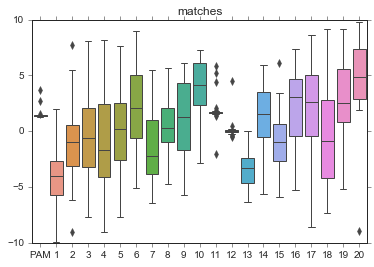

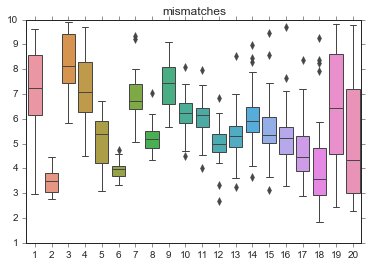

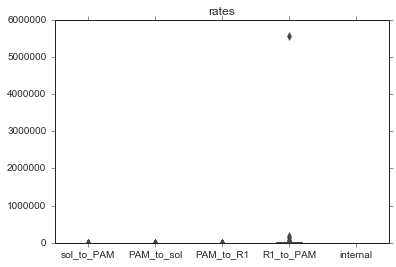

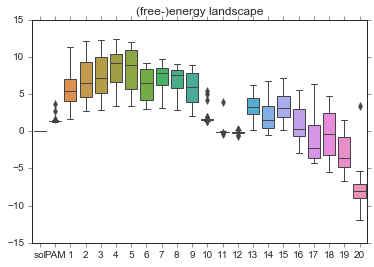

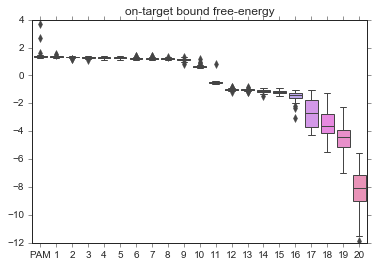

In [4]:
plt.figure()
sns.boxplot(data=matches)
plt.title('matches')

plt.figure()
sns.boxplot(data=mismatches)


plt.title('mismatches')

plt.figure()
sns.boxplot(data=rates)
plt.title('rates')

plt.figure()
sns.boxplot(data=landscape)
plt.title('(free-)energy landscape')

plt.figure()
sns.boxplot(data=free_energy)
plt.title('on-target bound free-energy')

# Averaged on-target energy landscape  

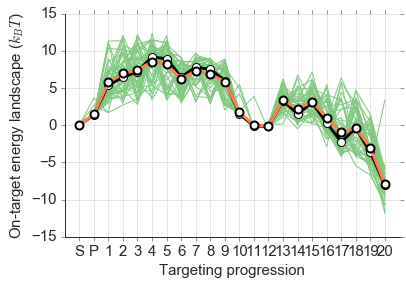

In [5]:
sns.set_palette('Accent')
model_id = 'init_limit_general_energies_v2'
Nparams = 44

for filename in simset:
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id,show_plot=False);
    plt.plot(np.array(Energy_landscape),color=sns.color_palette()[0])

LandscapeMED = landscape[landscape.columns[:]].median()
plt.plot(np.array(LandscapeMED),color='black' , 
             marker='o',
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 1);

LandscapeAVG = landscape[landscape.columns[:]].mean()
plt.plot(np.array(LandscapeAVG), color='coral' , 
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2);


plt.xlim(-1,22)
plt.xticks(range(0,22),['S','P']+list(LandscapeAVG.index[2:]),  fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('On-target energy landscape ($k_BT$)',fontsize=15)
plt.grid('on')
sns.despine()


# Fitting the internal forward rate (kf) for the averaged landscape
### We assume that the PAM binding is equilibrated

In [14]:
reload(SAfits);
reload(FreeEnergy);
mode = 'median'

if mode == 'mean':
    _, _, kOT = SAfits.average_solution(simset)
elif mode =='median':
    _, _, kOT = SAfits.median_solution(simset)
print 'on target binding rate: ', kOT * 1000 

forward_rates = [i*1 for i in range(2,1000)] + [100]
V, kf_vals, kf_opt, parameters_opt, V_opt = SAfits.optimize_forward_rate(simset,forward_rates, mode=mode)

print 'optimum found at an internal rate of ', kf_opt

on target binding rate:  0.341860588725
optimum found at an internal rate of  289


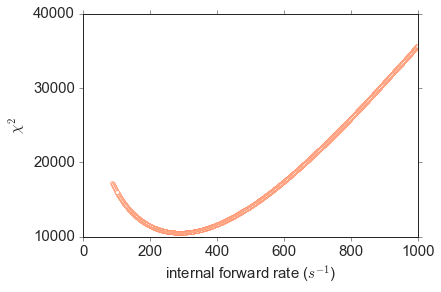

In [40]:
plt.plot(kf_vals,V, 
             linestyle='',
             color='coral' , 
             marker='.',
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 0.5);

plt.xlabel('internal forward rate ($s^{-1}$)', fontsize=15)
plt.ylabel('$\chi^{2}$', fontsize=15)
plt.xticks(np.arange(0,1200,200), fontsize=15)
plt.yticks(np.arange(10000,42000,10000), fontsize=15);



# Simulating Boyle data with the optimal parameter set

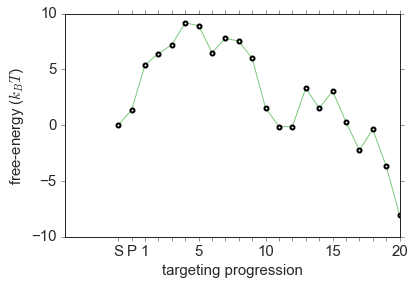

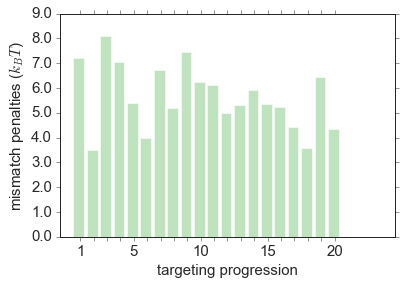

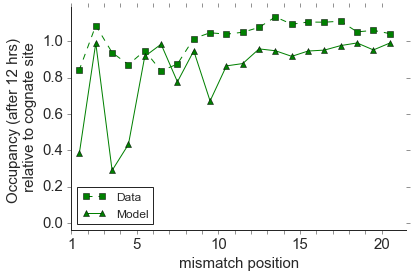

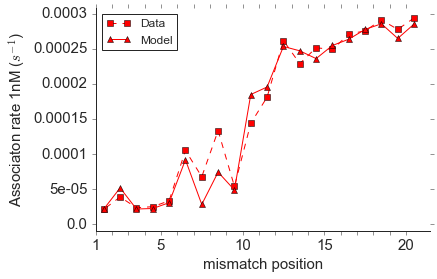

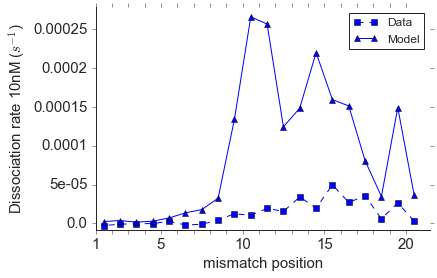

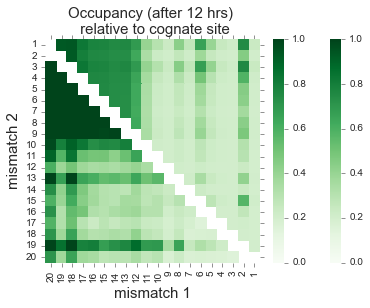

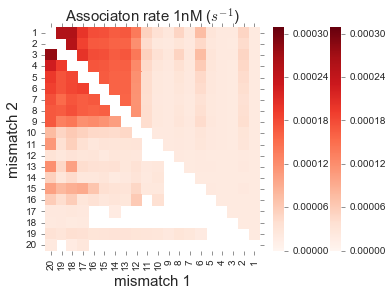

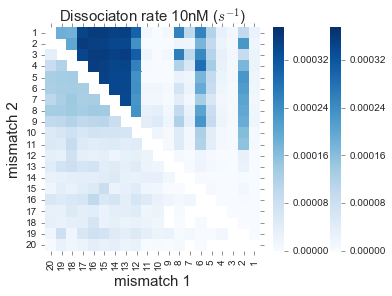

In [41]:
Model_pbound, Model_on, Model_off = plt_B.calc_predictions(parameters_opt,model_id)


Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters_opt,model_id,show_plot=False);           
plt.figure()
plt.plot(range(-1,21),Energy_landscape,
        marker='o',
        markerfacecolor='white',
        markeredgewidth=2,
        markersize=4,
        )

plt.xlabel('targeting progression', fontsize=15)
plt.ylabel(r'free-energy ($k_BT$)',fontsize=15)
plt.xticks(range(-1,21),['S', 'P',1,'', '', '', 5, '', '', '', '', 10, '', '', '', '', 15, '', '', '', '', 20],
                    rotation=0,
                    fontsize=15);
plt.yticks(fontsize=15)


plt.figure()
FreeEnergy.plot_mismatch_penalties(parameters_opt, model_id)

plt.figure()
plt_B.plot_single_mismatches(Model_pbound ,kind='Occupancy')

plt.figure()
plt_B.plot_single_mismatches(Model_on ,kind='OnRate')

plt.figure()
plt_B.plot_single_mismatches(Model_off ,kind='OffRate')

plt.figure()
plt_B.plot_heatmap(Model_pbound ,kind='Occupancy')

plt.figure()
plt_B.plot_heatmap(Model_on ,kind='OnRate')

plt.figure()
plt_B.plot_heatmap(Model_off ,kind='OffRate')


### saving the optimal parameter set

In [42]:
today = '07/11/2018' 
model_id = 'init_limit_general_energies_v2'


fit_info = '42 in total ,  folder 25_10_2018/sims: 1 - 50 & 19_10_2018'
mode = 'median'
filename = '../data/25_10_2018/median_landscape_Boyle.txt'

SAfits.write_parameters(parameters_opt, model_id, filename,today, fit_info, mode)

# Compare to Finkelstein lab data 

In [45]:
sys.path.append('../code_ABA_Finkelsteinlab/')
import plotting_ABA as pltABA
reload(pltABA);


IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')

BlockMismatches, _,ABA_first_mm_pos = pltABA.plot_block_mm_ABA(IlyaData, 
                                                               SaveFigures=False,
                                                               figure_names=[''],Plot=False );

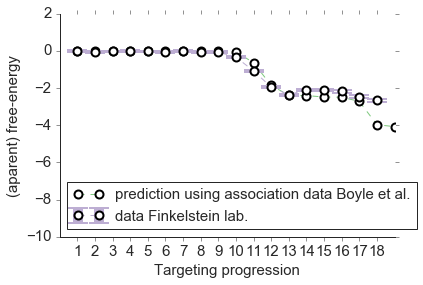

In [46]:
ABA_landscape = ABA_first_mm_pos['Delta ABA (kBT)'] - ABA_first_mm_pos['Delta ABA (kBT)'][0]
FreeEnergy_landscape_shifted = FreeEnergy_landscape - FreeEnergy_landscape[0]


plt.plot(range(1,len(FreeEnergy_landscape_shifted)+1),FreeEnergy_landscape_shifted,
        marker='o',
        markersize=8,
        markerfacecolor='white',
        markeredgewidth=2,
        linestyle='dashed',
        label='prediction using association data Boyle et al.')
plt.errorbar(range(1,len(ABA_landscape)+1),ABA_landscape,
        yerr=np.array(ABA_first_mm_pos['Uncertainty']),
        elinewidth=10,
        capsize=10,
        marker='o',
        markersize=8,
        markerfacecolor='white',
        markeredgewidth=2,
        linestyle='dashed',
        label='data Finkelstein lab.')
plt.xlim(0,19);
# plt.ylim(-4.0,0.0);
plt.xticks(range(1,19),fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('(aparent) free-energy',fontsize=15)
plt.legend(loc='best',frameon=True,fontsize=15);
sns.despine();